In [1]:
import blenderproc as bproc
import argparse
import numpy as np
import bpy
import time
import math
from pathlib import Path

## Load datas
* Rotation matrices
* Z offset from table surface

In [2]:
classes = ['mainshell', 'topshell', 'insert_mold']

R = []
Z = []
Z_freq = []
builds = ["legacy", "UT1113-11901-7H", "UT12113-120BK-7H"]

for catogory in classes:
    loaded = np.load(f"./pose_exp/convexhull_UT1113/{catogory}.npz")
    # loaded = np.load(f"./pose_exp/{builds[0]}/{catogory}.npz")
#     loaded = np.load(f"./{catogory}.npz")
    R_temp = loaded['Rotation']
    Z_temp = loaded['Z_offset']
    # remove Thickness_of_tagboard
    # unit: mm
    Z_temp = ((Z_temp - np.ones(shape=Z_temp.shape)*0.01) * 1000).round(1)
    # Z_temp = ((Z_temp - np.ones(shape=Z_temp.shape)*0.01)).round(4)
    # Z_temp = ((Z_temp) )
    R.append(R_temp)
    Z.append(Z_temp)
    ## TODO(yangfei) Z_off - Thickness_of_tagboard

    Z_freq_temp = {}
    for item in Z_temp:
        Z_freq_temp[item] = Z_freq_temp.get(item, 0) + 1
    
    total = sum(Z_freq_temp.values())
    for key, value in Z_freq_temp.items():
        Z_freq_temp[key] = round((Z_freq_temp[key] / total), 2)
    Z_freq.append(Z_freq_temp)
    
    print(f"{catogory} frequency dic is ", Z_freq[-1])
    print(f"{catogory} Min Z value = ", Z_temp.min())
    print(f"{catogory} Max Z value = ", Z_temp.max(), '\n')


mainshell frequency dic is  {-6.7: 0.63, -5.6: 0.33, -4.0: 0.03, -3.1: 0.02, -6.2: 0.0, -6.3: 0.0}
mainshell Min Z value =  -6.7
mainshell Max Z value =  -3.1 

topshell frequency dic is  {-6.9: 0.79, -4.1: 0.0, -4.5: 0.19, -7.0: 0.01, -3.0: 0.01, -5.0: 0.0}
topshell Min Z value =  -7.0
topshell Max Z value =  -3.0 

insert_mold frequency dic is  {-6.6: 0.59, -5.7: 0.39, -5.0: 0.0, -4.8: 0.0, -3.8: 0.01, -5.4: 0.0, -6.7: 0.0, -5.8: 0.0}
insert_mold Min Z value =  -6.7
insert_mold Max Z value =  -3.8 



## Z_off distrubution

{-6.7: 0.63, -5.6: 0.33, -4.0: 0.03, -3.1: 0.02, -6.2: 0.0, -6.3: 0.0}


([<matplotlib.axis.XTick at 0x7efcb23f93c0>,
 [Text(1.0, 0, 'mainshell'),
  Text(9.5, 0, 'topshell'),
  Text(18.5, 0, 'insert_mold')])

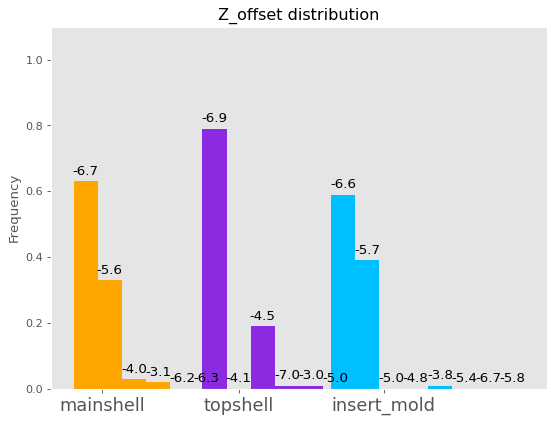

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
print(Z_freq[0])

colors = 'orange','blueviolet','deepskyblue'
plt.figure(figsize=(8, 6), dpi=80, facecolor='white')
plt.grid(False)
plt.gca().set(title="Z_offset distribution", ylabel="Frequency")
plt.rcParams['axes.facecolor']='snow'
plt.ylim(top=1.1)

for i in range(3):
    shift = 0
    for offset in Z_freq[i]:
        x = i*8 + shift
        plt.bar(x, Z_freq[i][offset], width=1.5, color=colors[i])
        plt.text(x, Z_freq[i][offset]+0.02, offset, ha='center',fontsize=12)
        shift += 1.5
    # plt.bar(x+1, 1.2*np.sin(x),width=1)

x_legend=[1, 9.5, 18.5]
plt.xticks(x_legend, classes, fontsize=16)

## Filter

In [4]:
len(R[0])
## if Z== _
## R.pop()

5000

## Rotation to euler angles

In [7]:
# Ref: https://learnopencv.com/rotation-matrix-to-euler-angles/
# Same method as MATLAB’s `rotm2euler`
def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    
    return n<1e-6
    print(R)
    print(Rt)

def R2Euler(R):
    assert(isRotationMatrix(R))
    
    sy = math.sqrt(R[0,0]*R[0,0] + R[1,0]*R[1,0])
    singular = sy < 1e-6
    
    if not singular:
        pitch_x = math.atan2(R[2,1], R[2,2])
        roll_y  = math.atan2(-R[2,0], sy)
        yaw_z   = math.atan2(R[1,0], R[0,0])
    else:
        pitch_x = math.atan2(-R[1,2], R[1,1])
        roll_y = math.atan2(-R[2,0], sy)
        yaw_z = 0
    
    pitch_x = round(math.degrees(pitch_x) ,0)
    roll_y =round(math.degrees(roll_y) ,0)
    yaw_z = round(math.degrees(yaw_z) ,1) 

    if abs(pitch_x)==0:
        pitch_x = abs(pitch_x)
    roll_y = abs(roll_y)

    if abs(pitch_x)==180 and abs(roll_y)==0:
        pitch_x = abs(pitch_x)

    return np.array([pitch_x, roll_y, yaw_z])

np.set_printoptions(suppress=True)



Euler_set = []
for Rot in R:
    poses = [] 
    for pose in Rot:
        poses.append(R2Euler(pose))
    Euler_set.append(poses)

Euler_dics = []
for Eulers in Euler_set:
    temp_dic = {}
    for Euler in Eulers:
        Euler = str(Euler[:2])
        temp_dic[Euler] = temp_dic.get(Euler, 0) + 1
    Euler_dics.append(temp_dic)

for i in range(1, len(Euler_dics)):
    # print('#'*35)
    print(f'[Pithc, Roll] angles for {classes[i]}')
    print('#'*35)
    for pose,num in Euler_dics[i].items():
        print(pose, '\t num =', num)
    print('\n')

[Pithc, Roll] angles for mainshell
###################################
[180.   0.] 	 num = 3126
[-12.   0.] 	 num = 1627
[-90.   0.] 	 num = 164
[90.  0.] 	 num = 76
[-10.   1.] 	 num = 2
[89.  0.] 	 num = 1
[-15.   3.] 	 num = 1
[-12.   2.] 	 num = 1
[-11.   4.] 	 num = 2


[Pithc, Roll] angles for topshell
###################################
[180.   0.] 	 num = 4000
[-90.   0.] 	 num = 24
[0. 0.] 	 num = 935
[179.   0.] 	 num = 2
[90.  0.] 	 num = 29
[180.   1.] 	 num = 5
[-179.    0.] 	 num = 1
[2. 1.] 	 num = 1
[-180.    1.] 	 num = 2
[-179.    2.] 	 num = 1


[Pithc, Roll] angles for insert_mold
###################################
[180.   0.] 	 num = 2944
[-25.   0.] 	 num = 1956
[31.  0.] 	 num = 18
[90.  0.] 	 num = 16
[-49.  73.] 	 num = 13
[-178.    0.] 	 num = 3
[-49.  74.] 	 num = 10
[-180.    1.] 	 num = 2
[-177.    1.] 	 num = 2
[145.   0.] 	 num = 1
[-179.    0.] 	 num = 14
[-177.    0.] 	 num = 5
[ 0. 83.] 	 num = 6
[-1. 83.] 	 num = 1
[-24.   0.] 	 num = 1
[-176.    0.]

In [30]:
print(R[2][74])
print(R2Euler(R[2][74]))
print(R[2][89])
print(R2Euler(R[2][89]))

[[-0.15622975 -0.88914251 -0.43013698]
 [-0.28804117 -0.37554249  0.88090867]
 [-0.9447881   0.26152131 -0.19743875]]
[ 127.1   70.9 -118.5]
[[ 0.55952346 -0.68801129  0.46214068]
 [-0.82881451 -0.46450207  0.31193638]
 [ 0.00004956 -0.55756462 -0.83013356]]
[-146.1   -0.   -56. ]


In [6]:
round(1.9, 0)

2.0